In [ ]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PowerTransformer
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import zscore


In [ ]:

aq_df = pd.read_csv('/content/drive/MyDrive/softwarica/machine-learning/air-quality-prediction-classification/kathmandu_aq_us_embassy_till_2025_4.csv')             # Air Quality Data
mt_df = pd.read_csv('/content/drive/MyDrive/softwarica/machine-learning/air-quality-prediction-classification/kathmandu_weather_2020_1_to_2025_4.csv')        # Meteorological Data
hd_df = pd.read_csv("/content/drive/MyDrive/softwarica/machine-learning/air-quality-prediction-classification/nepal_holidays_2020_1_to_2025_4_with_weekends.csv")  # Holiday Data


#  Exploratory Data Analysis

In [ ]:
# print(aq_df.sample(5))
print(aq_df.info())
# print(aq_df.describe())
# print(aq_df.shape)

# print(mt_df.head(5))
print(mt_df.info())
# print(mt_df.describe())
# print(mt_df.shape)

print(hd_df.sample(5))
print(hd_df.info())
# print(hd_df.describe())
# print(hd_df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2766 entries, 0 to 2765
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    2766 non-null   object
 1    pm25   2766 non-null   object
 2    pm10   2766 non-null   object
dtypes: object(3)
memory usage: 65.0+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87746 entries, 0 to 87745
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   timestamp      87746 non-null  object 
 1   temperature    87746 non-null  float64
 2   dew_point      87746 non-null  float64
 3   humidity       87746 non-null  float64
 4   wind           87557 non-null  object 
 5   wind_speed     87746 non-null  float64
 6   wind_gust      87746 non-null  float64
 7   pressure       87746 non-null  float64
 8   precipitation  87746 non-null  float64
 9   condition      87746 non-null  object 
dtypes: float64(7), object(3)
m

In [ ]:
# Clean & Prepare Air Quality Data
aq_df.columns = aq_df.columns.str.strip()                                               # Strip leading/trailing spaces from column names
aq_df['date'] = pd.to_datetime(aq_df['date'], format='%Y/%m/%d', errors='coerce')       # Convert date column to datetime
aq_df.drop(columns=['pm10'], inplace=True)                                              # Drop pm10 Column
aq_df = aq_df[(aq_df['date'] >= '2020-01-01') & (aq_df['date'] <= '2025-04-25')].copy() # Filter by date
aq_df['pm25'] = pd.to_numeric(aq_df['pm25'], errors='coerce')                           # Convert pm25 to numeric (coerce invalid entries to NaN)
aq_df.sort_values('date', inplace=True)                                                 # Ensure it's sorted by date

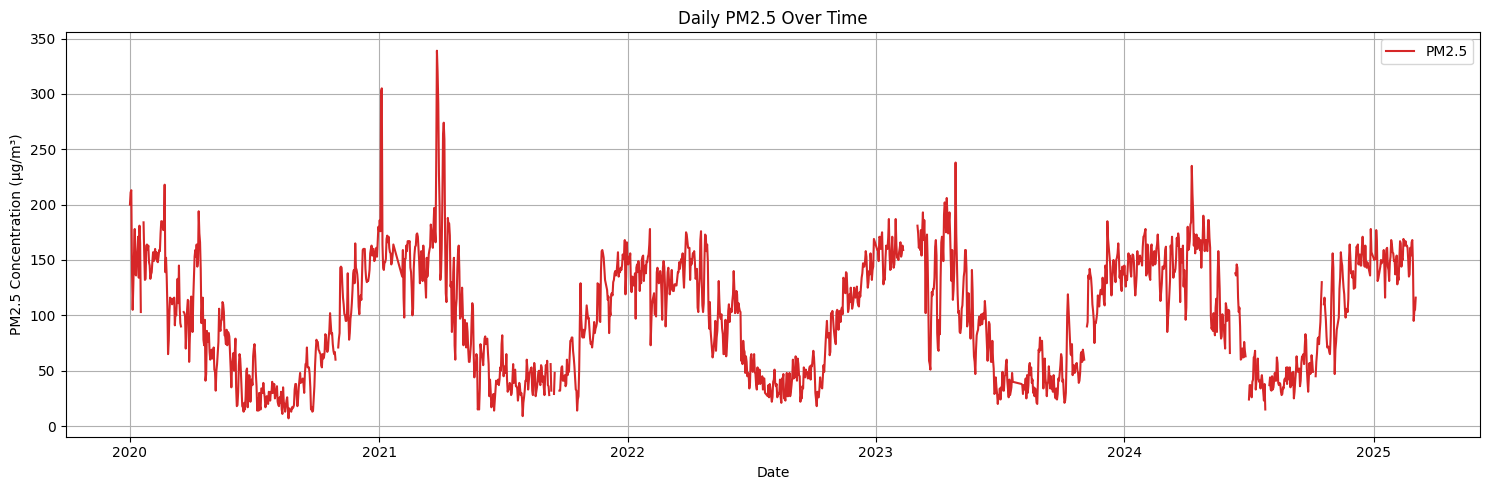

None


<ipython-input-10-5ee42fd2e43c>:13: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  aq_df['pm25_zscore'] = zscore(aq_df['pm25'].fillna(method='ffill'))


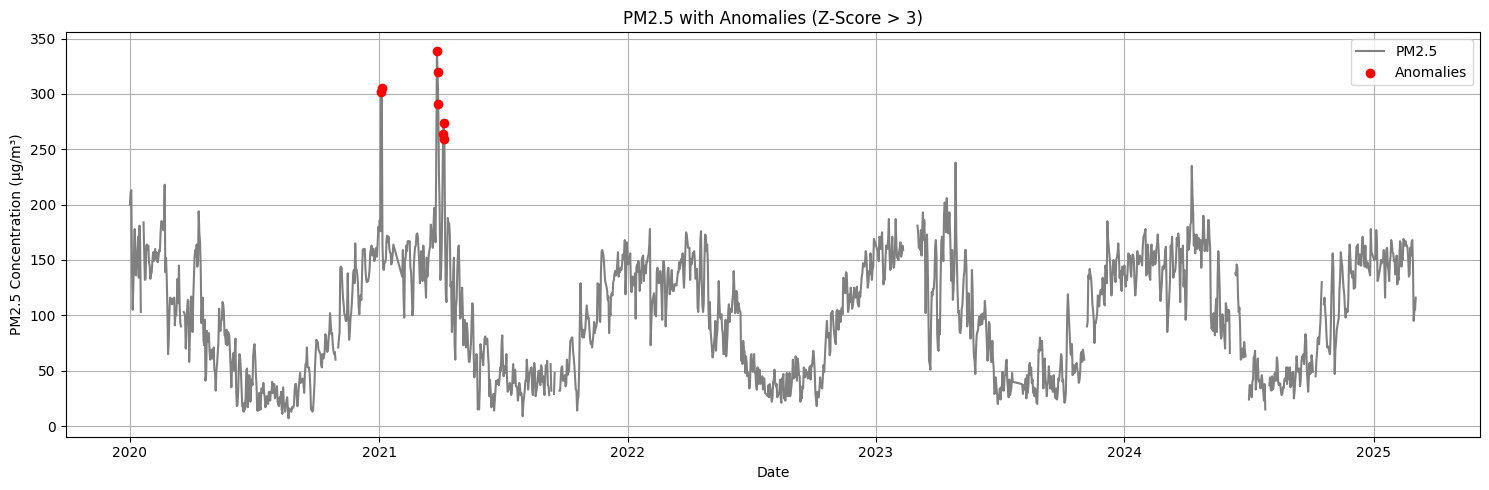

None


In [ ]:
# Plot the PM2.5 against the dates (2020-2025)
plt.figure(figsize=(15, 5))
plt.plot(aq_df['date'], aq_df['pm25'], label='PM2.5', color='tab:red')
plt.title('Daily PM2.5 Over Time')
plt.xlabel('Date')
plt.ylabel('PM2.5 Concentration (μg/m³)')
plt.grid(True)
plt.legend()
plt.tight_layout()
print(plt.show())

# Hilight the anomalies
aq_df['pm25_zscore'] = zscore(aq_df['pm25'].fillna(method='ffill'))
# Mark anomalies
threshold = 3
anomalies = aq_df[np.abs(aq_df['pm25_zscore']) > threshold]
plt.figure(figsize=(15, 5))
plt.plot(aq_df['date'], aq_df['pm25'], label='PM2.5', color='gray')
plt.scatter(anomalies['date'], anomalies['pm25'], color='red', label='Anomalies', zorder=5)
plt.title('PM2.5 with Anomalies (Z-Score > 3)')
plt.xlabel('Date')
plt.ylabel('PM2.5 Concentration (μg/m³)')
plt.legend()
plt.grid(True)
plt.tight_layout()
print(plt.show())



> These anomalies/spikes of PM2.5 during January and March of 2021 are genuine as the air quality suffered unprecedented air quality deterioration due to combination of factors, including winter inversion, vehicular emmisions, wildfires and cross-border industrial pollution in January 2021. Similarly in March 2021, Nepal faced extensive wildfires, with incidents reported in 73 districts. These fires were exacerbated by an unusually dry winter, with precipitation levels significantly below average. Thus, the spikes here shall be left as it is.





In [ ]:
# Standard Classes
# def classify_pm25(pm):
#     if pm <= 12:
#         return 'Good'
#     elif pm <= 35.4:
#         return 'Moderate'
#     elif pm <= 55.4:
#         return 'Unhealthy for Sensitive Groups'
#     elif pm <= 150.4:
#         return 'Unhealthy'
#     elif pm <= 250.4:
#         return 'Very Unhealthy'
#     else:
#         return 'Hazardous'
def classify_pm25(pm):
    if pm <= 35.4:
        return 'Low'       # Merged Good + Moderate
    elif pm <= 55.4:
        return 'Moderate'  # UGS
    elif pm <= 150.4:
        return 'Unhealthy'
    elif pm <= 250.4:
        return 'Very Unhealthy'
    else:
        return 'Hazardous'


aq_df['pm25_class'] = aq_df['pm25'].apply(classify_pm25)

In [ ]:
# print(aq_df['pm25'].value_counts())
# print(aq_df['pm25'].describe())

In [ ]:
# Clean & Prepare Meteorological Data
mt_df = mt_df.drop(columns=["precipitation"])               # Drop precipitation as it has all 0 values
mt_df['timestamp'] = pd.to_datetime(mt_df['timestamp'])      # convert timestamp to datetime
mt_df['temperature'] = mt_df['temperature'].apply(lambda x: np.round((x - 32) * 5/9))   # Convert Fahrenheit to Celcius
mt_df['dew_point'] = mt_df['dew_point'].apply(lambda x: np.round((x - 32) * 5/9))      # Convert Fahrenheit to Celcius
mt_df['wind_speed'] = mt_df['wind_speed'].apply(lambda x: np.round(x * 1.60934))      # Convert wind speed from miles per hour to kmph
mt_df['wind_gust'] = mt_df['wind_gust'].apply(lambda x: np.round(x * 1.60934))      # Convert wind speed from miles per hour to kmph
mt_df['pressure'] = mt_df['pressure'].apply(lambda x: int(np.round(x * 33.8639)))     # Convert pressure from inches of Mercury (inHg) to hectopascals (hPa)
mt_df['wind'] = mt_df['wind'].bfill()     # Backward Fill missing values for wind with
mt_df.sort_values('timestamp', inplace=True)

In [ ]:
# Scale values
# Separate numerical and non-numerical columns for scaling
numerical_cols_mt = mt_df.select_dtypes(include=np.number).columns.tolist()
non_numerical_cols_mt = ['timestamp', 'condition', 'date']
numerical_cols_mt = list(set(numerical_cols_mt) - set(non_numerical_cols_mt))

# Apply StandardScaler to numerical columns in mt_df
scaler_mt = StandardScaler()  # Important: Create a scaler for mt_df
mt_df_scaled = mt_df.copy()
mt_df_scaled[numerical_cols_mt] = scaler_mt.fit_transform(mt_df[numerical_cols_mt])

mt_df = mt_df_scaled

In [ ]:
# Function to plot yearly trends in different columns
def plot_yearly_grid(df, date_col='timestamp', value_col='temperature',
                    title_prefix='Temperature', figsize=(20, 12)):
    df = df.copy()
    df['year'] = df[date_col].dt.year
    years = sorted(df['year'].unique())
    n_years = len(years)
    cols = min(3, n_years)  # Max 3 columns
    rows = (n_years + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=figsize, sharex=False, sharey=True)

    if rows == 1 and cols == 1:
        axes = [axes]
    elif rows == 1 or cols == 1:
        axes = axes.flatten()
    else:
        axes = axes.flatten()

    for i, year in enumerate(years):
        if i >= len(axes):
            break

        year_data = df[df['year'] == year].copy()
        year_data['month_day'] = year_data[date_col].dt.strftime('%m-%d')
        if len(year_data) > 5000:
            step = len(year_data) // 3000
            year_data_sampled = year_data.iloc[::step]
        else:
            year_data_sampled = year_data
        ax = axes[i]
        # sns.lineplot(data=year_data_sampled,
        #             x=date_col, y=value_col,
        #             color='skyblue', linestyle='-', alpha=0.7, ax=ax)

        scatter_data = year_data_sampled.iloc[::5] if len(year_data_sampled) > 1000 else year_data_sampled
        sns.scatterplot(data=scatter_data,
                       x=date_col, y=value_col,
                       color='blue', s=30, alpha=0.8, ax=ax)

        ax.set_title(f'{title_prefix} - {year}', fontsize=14, fontweight='bold')
        ax.set_xlabel('Date', fontsize=12)
        ax.set_ylabel(value_col.title(), fontsize=12)
        ax.tick_params(axis='x', rotation=45, labelsize=10)
        # Month
        if len(year_data) > 100:
            month_starts = year_data.groupby([year_data[date_col].dt.month]).first()[date_col]
            ax.set_xticks(month_starts[::2])  # Every other month

    # Hide empty subplots
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    plt.show()


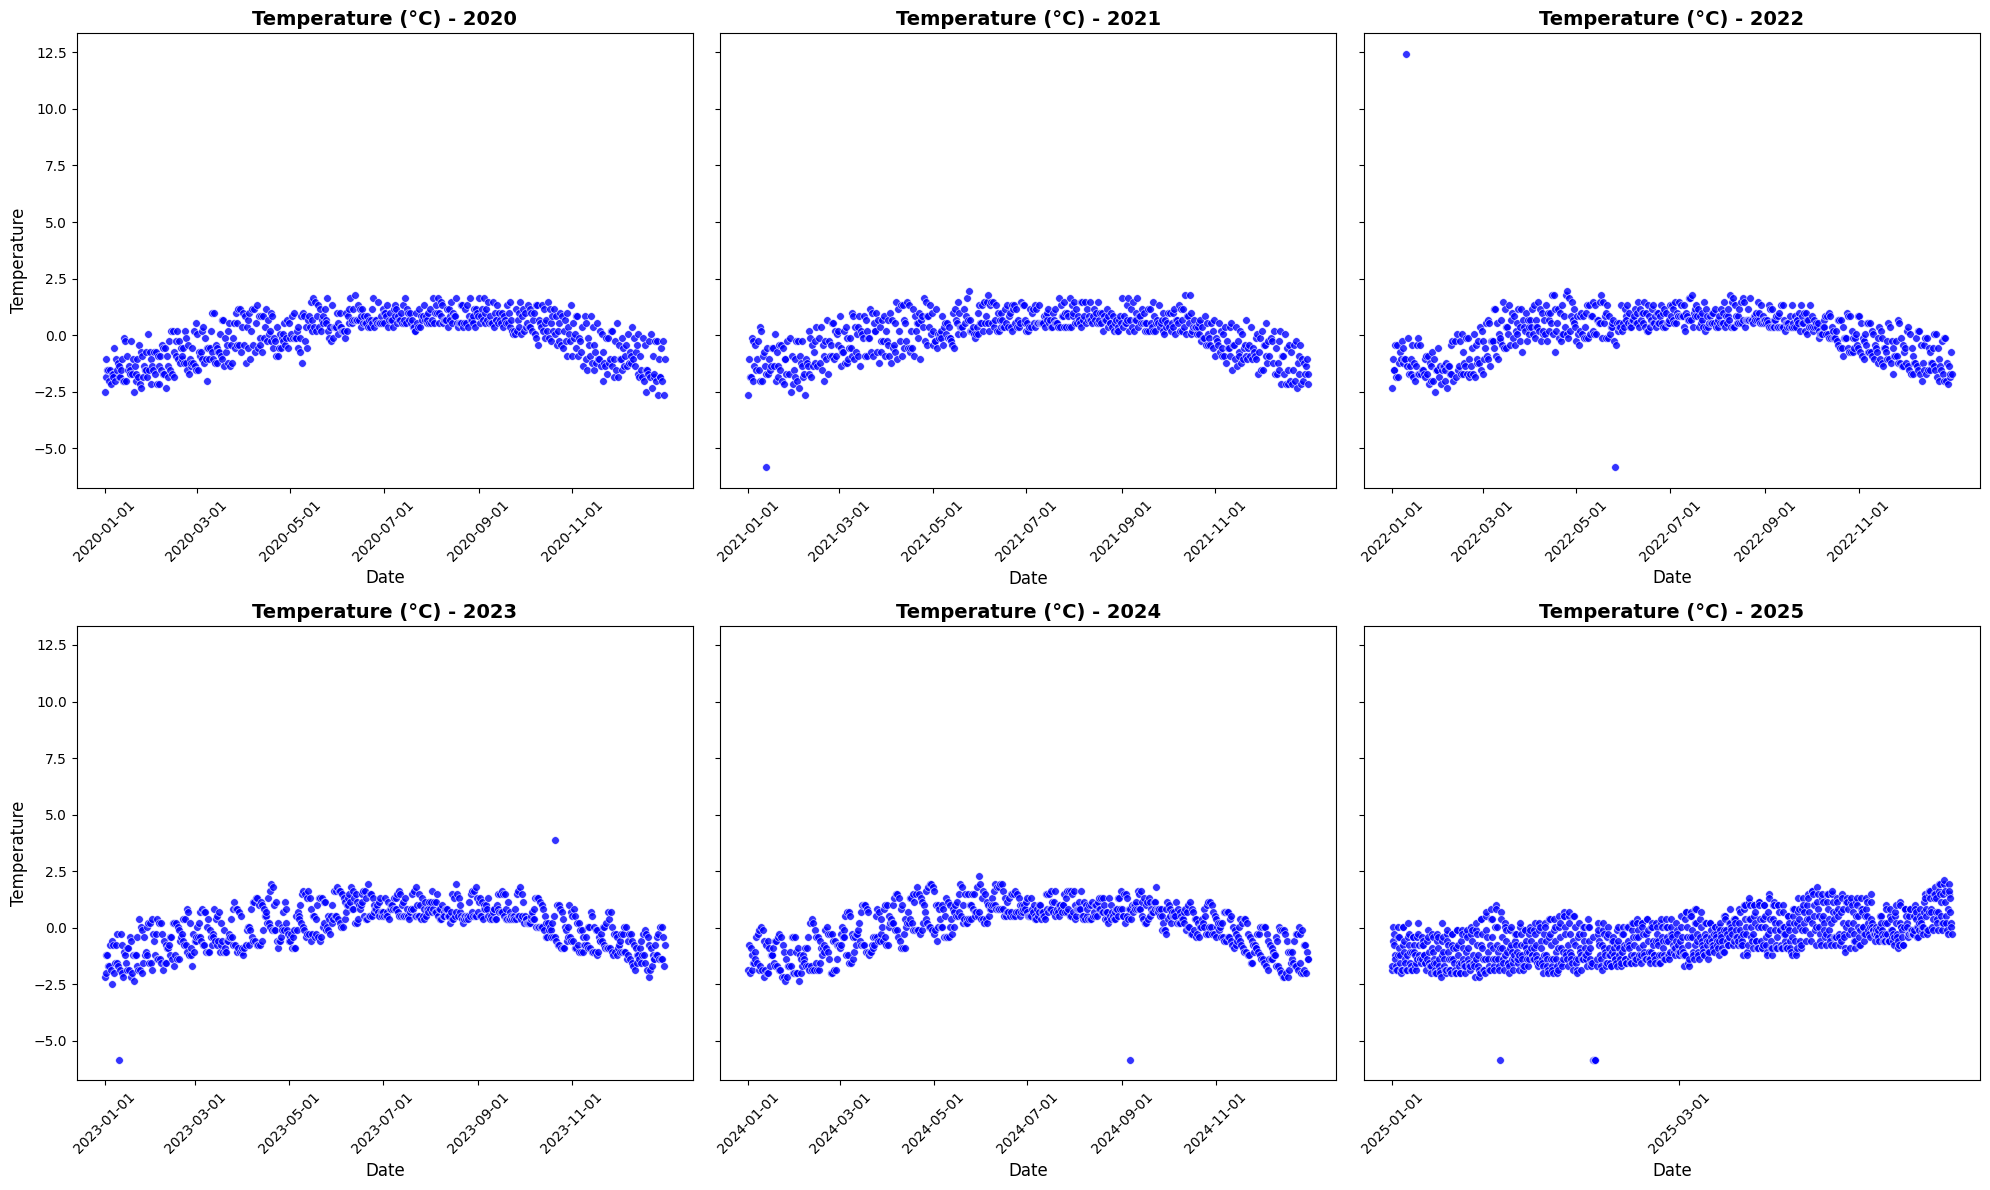

None


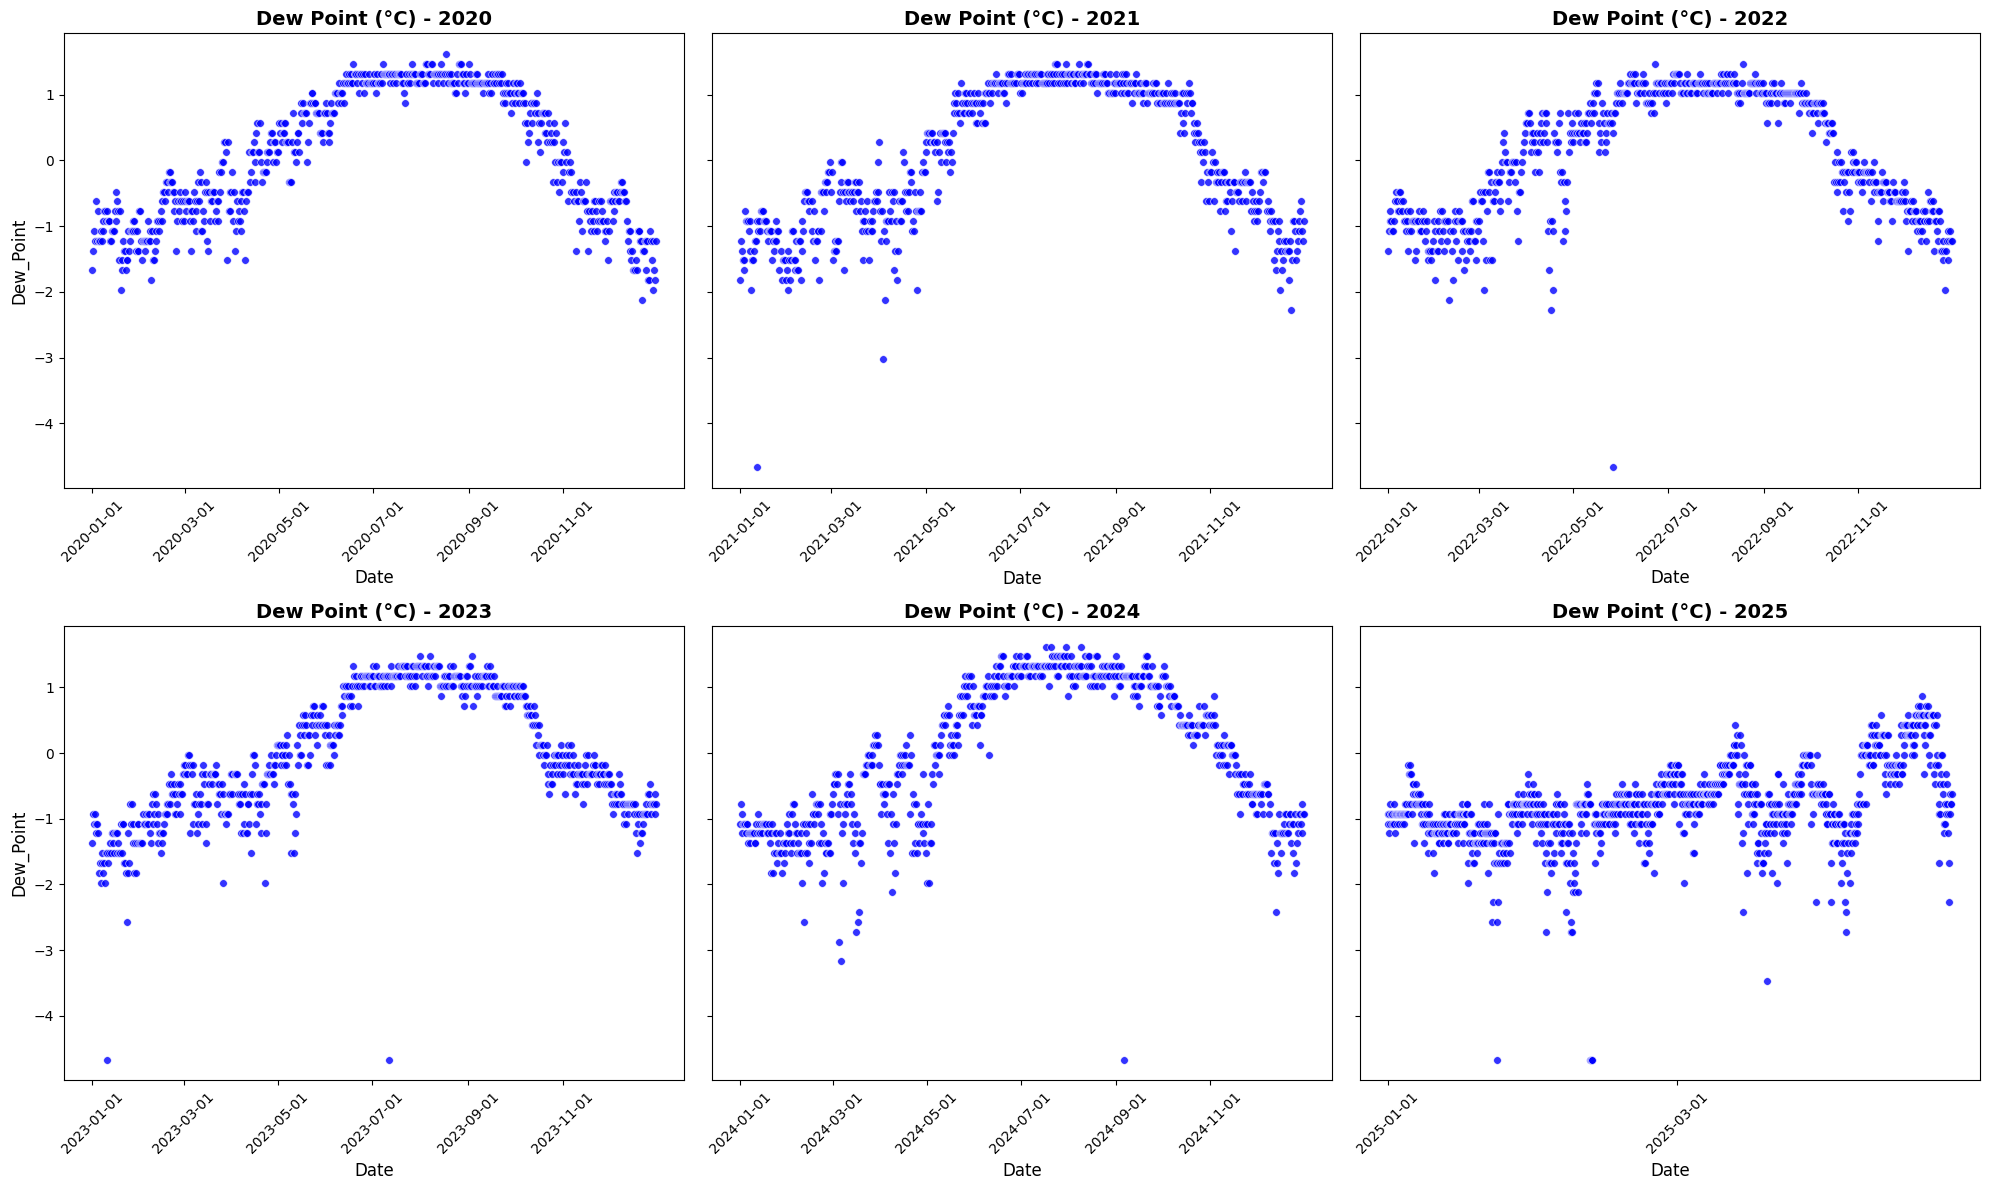

None


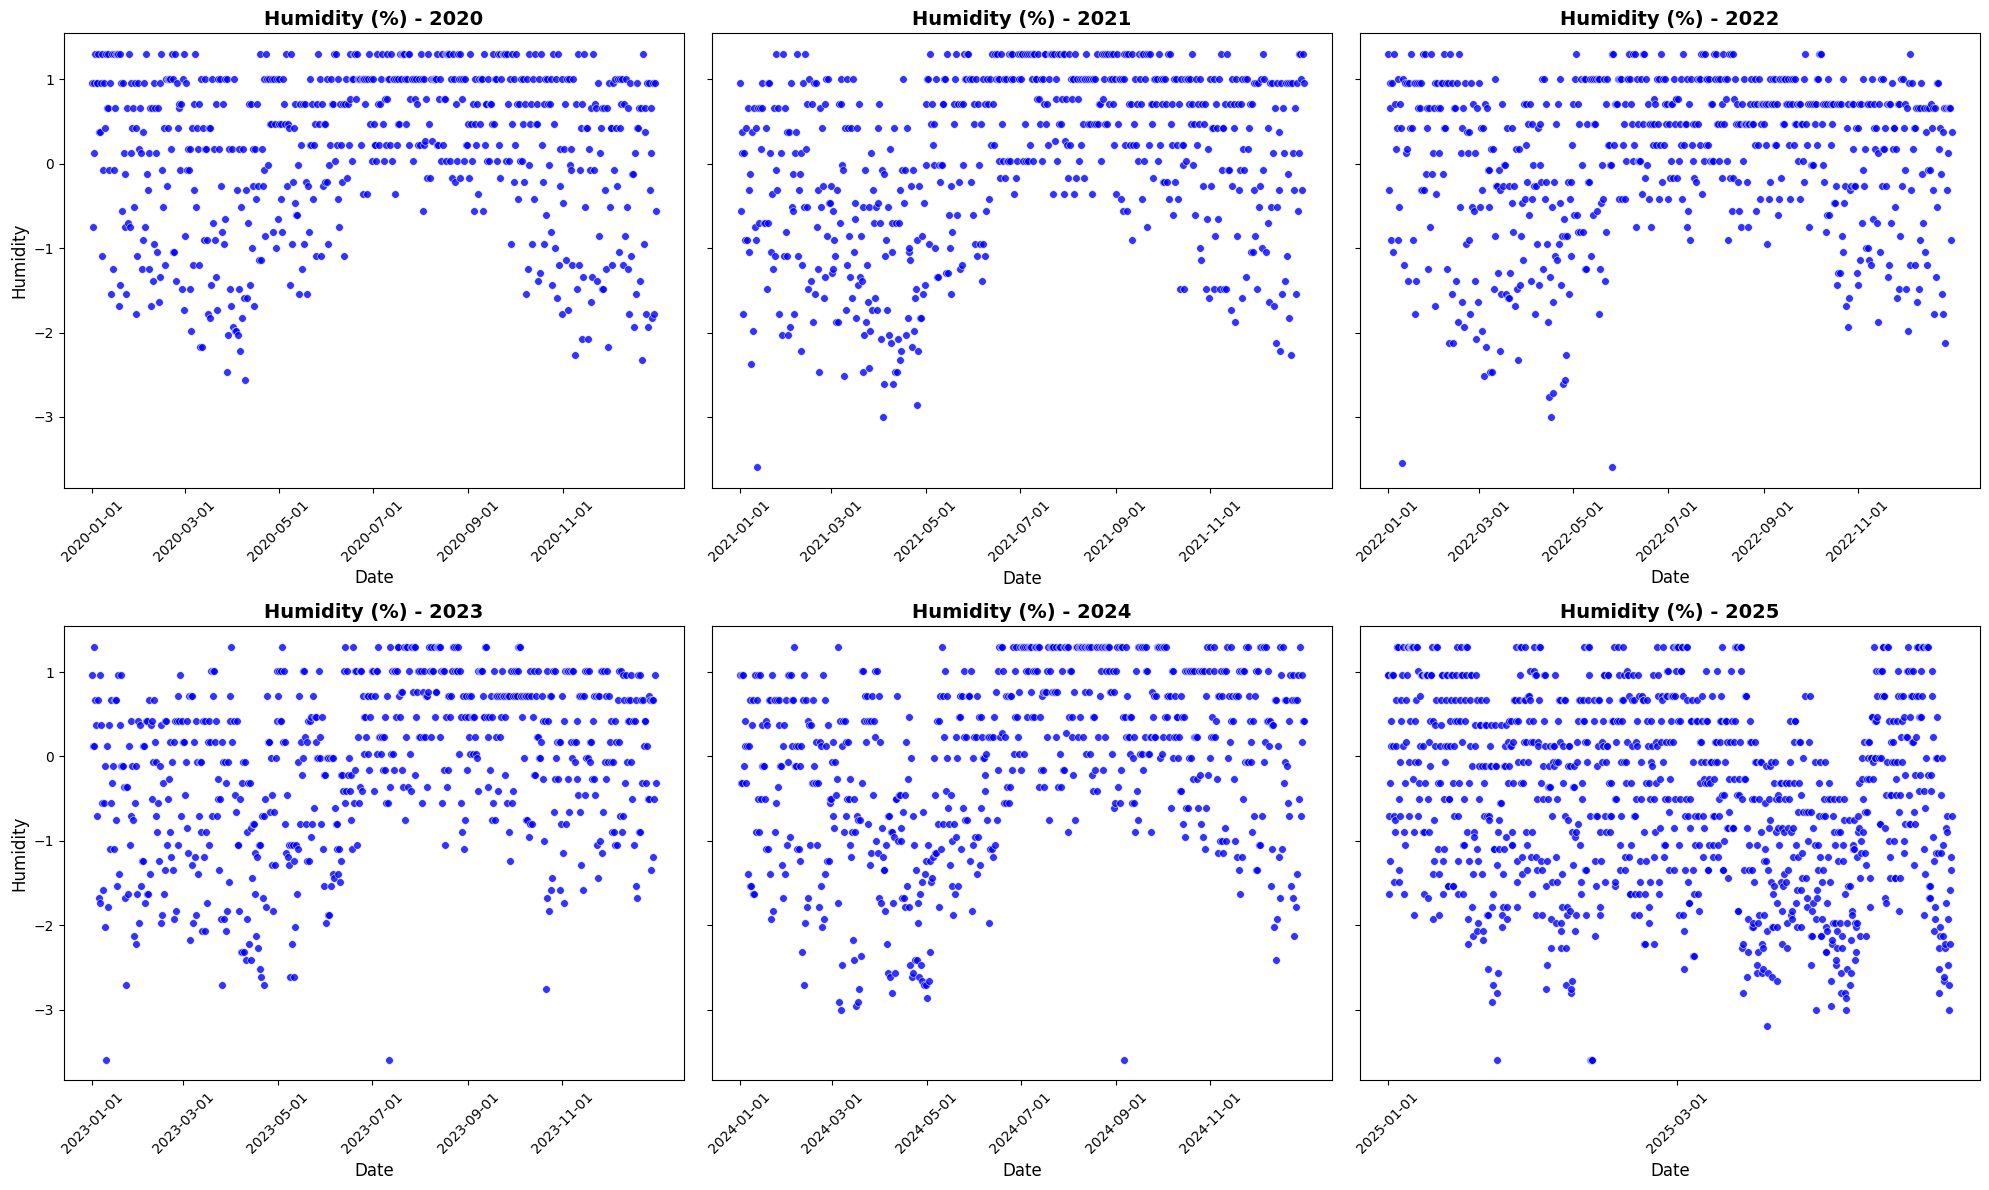

None


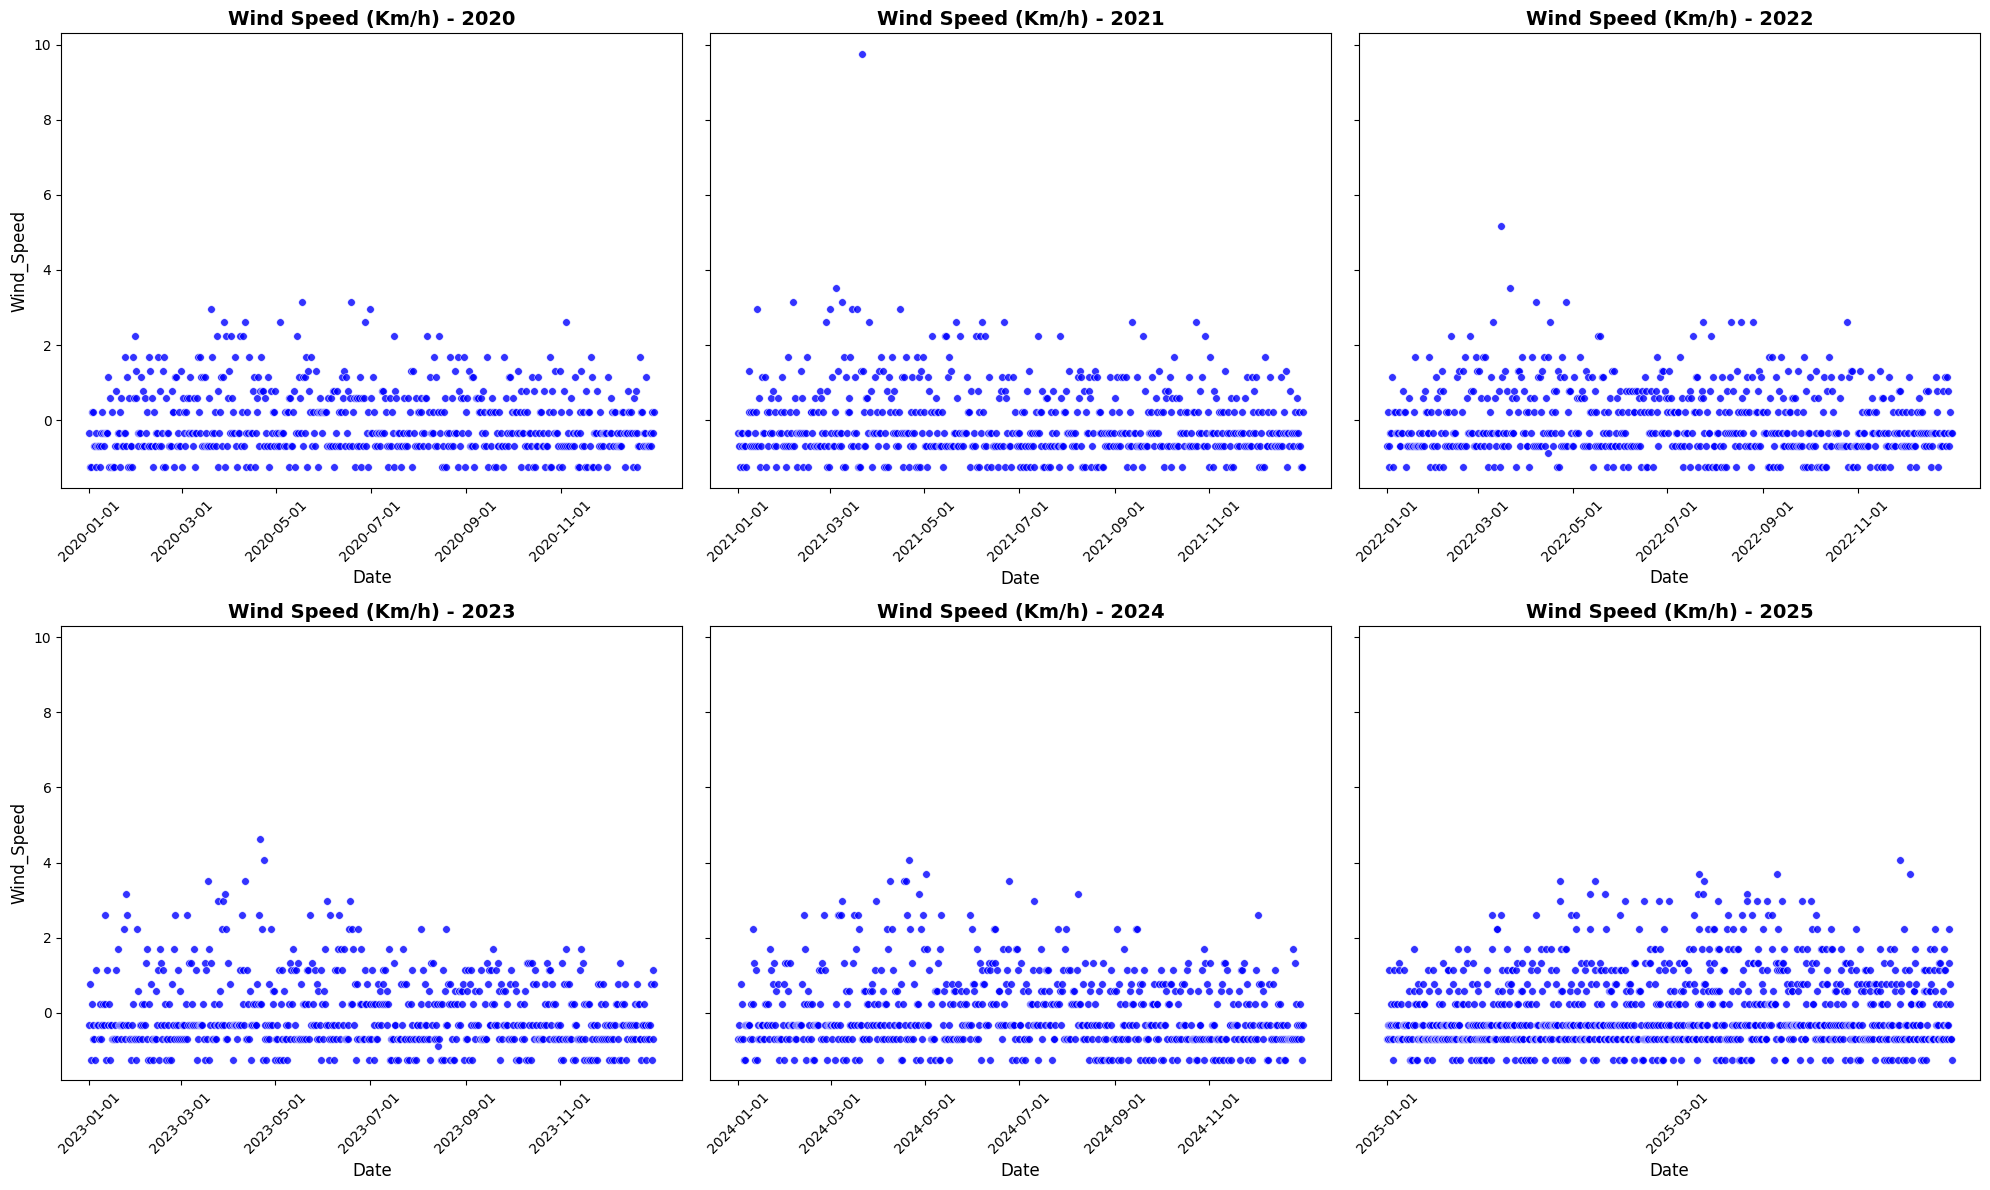

None


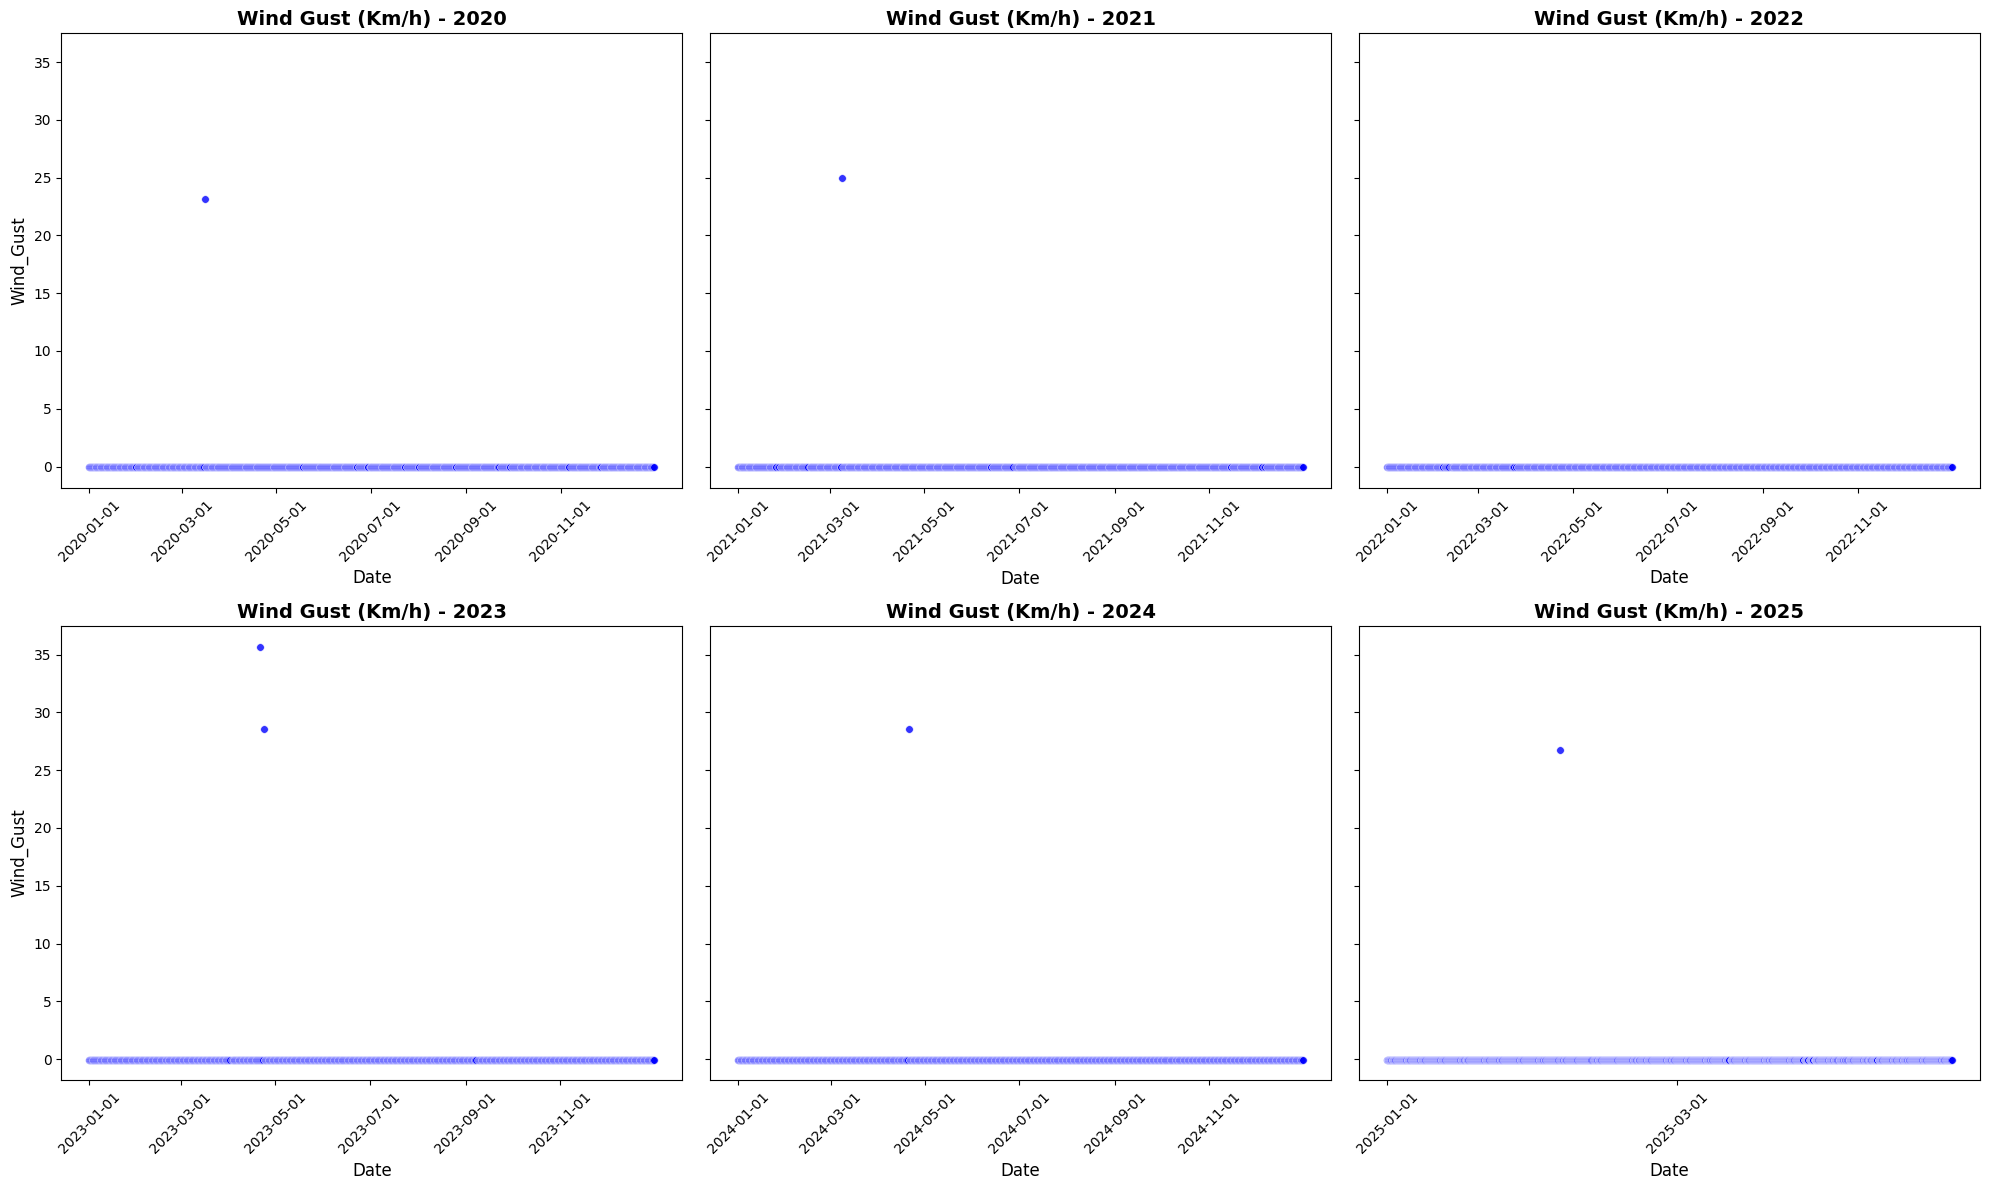

None


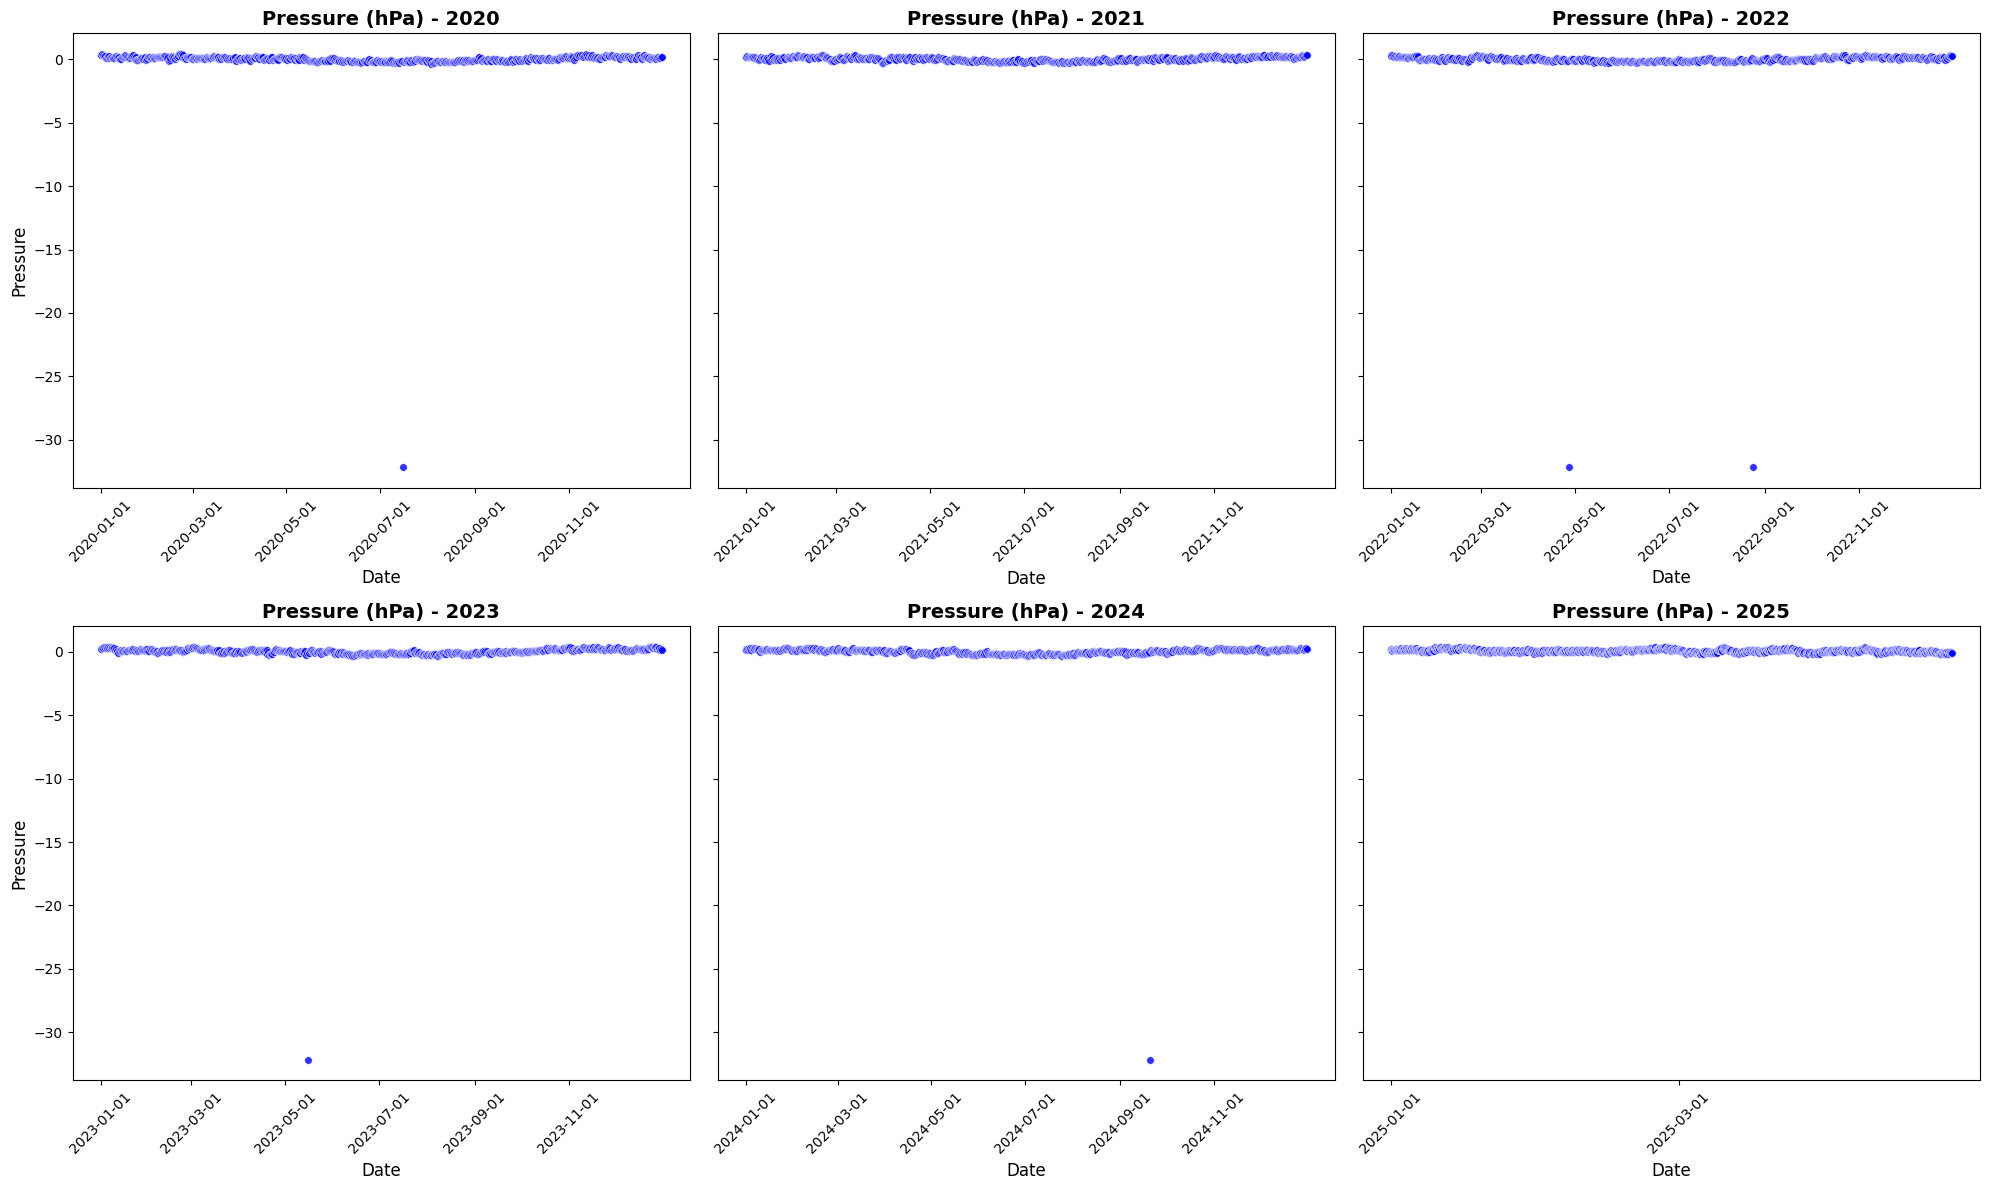

None


In [ ]:
print(plot_yearly_grid(mt_df,'timestamp', 'temperature', 'Temperature (°C)'))
print(plot_yearly_grid(mt_df,'timestamp', 'dew_point', 'Dew Point (°C)'))
print(plot_yearly_grid(mt_df,'timestamp', 'humidity', 'Humidity (%)'))
print(plot_yearly_grid(mt_df,'timestamp', 'wind_speed', 'Wind Speed (Km/h)'))
print(plot_yearly_grid(mt_df,'timestamp', 'wind_gust', 'Wind Gust (Km/h)'))
print(plot_yearly_grid(mt_df,'timestamp', 'pressure', 'Pressure (hPa)'))

## Handle Anomalies

In [ ]:
# Cap columns according to reported max and min values
mt_df['temperature'] = mt_df['temperature'].clip(lower=1.6, upper=35.3)
mt_df['pressure'] = mt_df['pressure'].clip(lower=855, upper=885)
mt_df['dew_point'] = mt_df['dew_point'].clip(lower=-10, upper=25) # As observed from the plots

# # mt_df['wind_gust'].value_counts() # 87611 0.0km/h out of 87746, suggests it wasn't recorded for the most part of data collection, so column can be dropped
mt_df.drop(columns=['wind_gust'], inplace=True)

# Map direction to degrees
direction_map = {
    'N': 0, 'NNE': 22.5, 'NE': 45, 'ENE': 67.5,
    'E': 90, 'ESE': 112.5, 'SE': 135, 'SSE': 157.5,
    'S': 180, 'SSW': 202.5, 'SW': 225, 'WSW': 247.5,
    'W': 270, 'WNW': 292.5, 'NW': 315, 'NNW': 337.5,
    'CALM': np.nan, 'VAR': np.nan
}
mt_df['wind_deg'] = mt_df['wind'].map(direction_map)

# Add binary indicators
mt_df['is_calm'] = (mt_df['wind'] == 'CALM').astype(int)
mt_df['is_var'] = (mt_df['wind'] == 'VAR').astype(int)


mt_df['wind_deg'] = mt_df['wind_deg'].fillna(0) #  Set NaN degrees to 0 for trigonometric encoding
mt_df['wind_sin'] = np.sin(np.deg2rad(mt_df['wind_deg']))
mt_df['wind_cos'] = np.cos(np.deg2rad(mt_df['wind_deg']))
mt_df.drop(columns=['wind'], inplace=True)


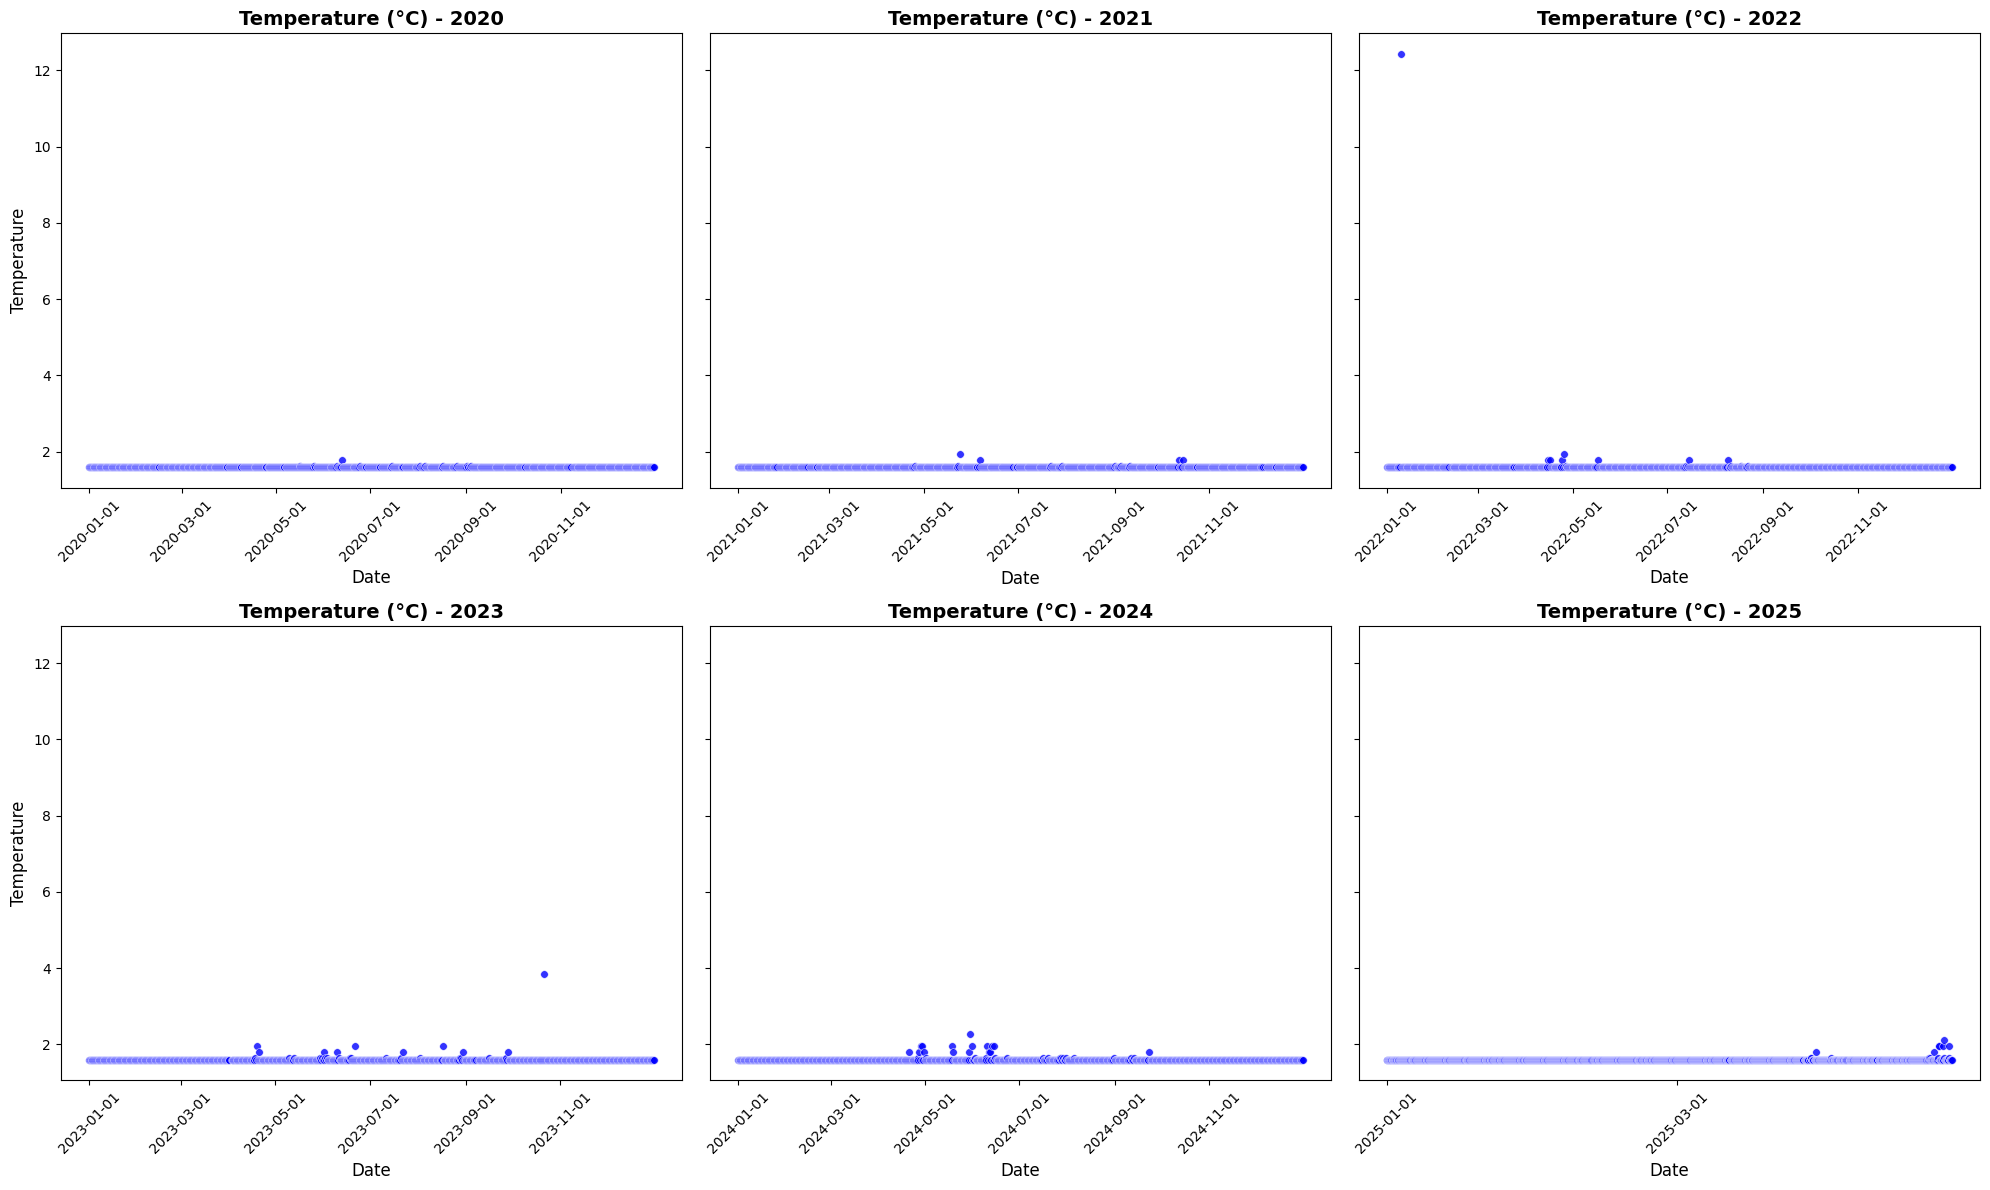

None


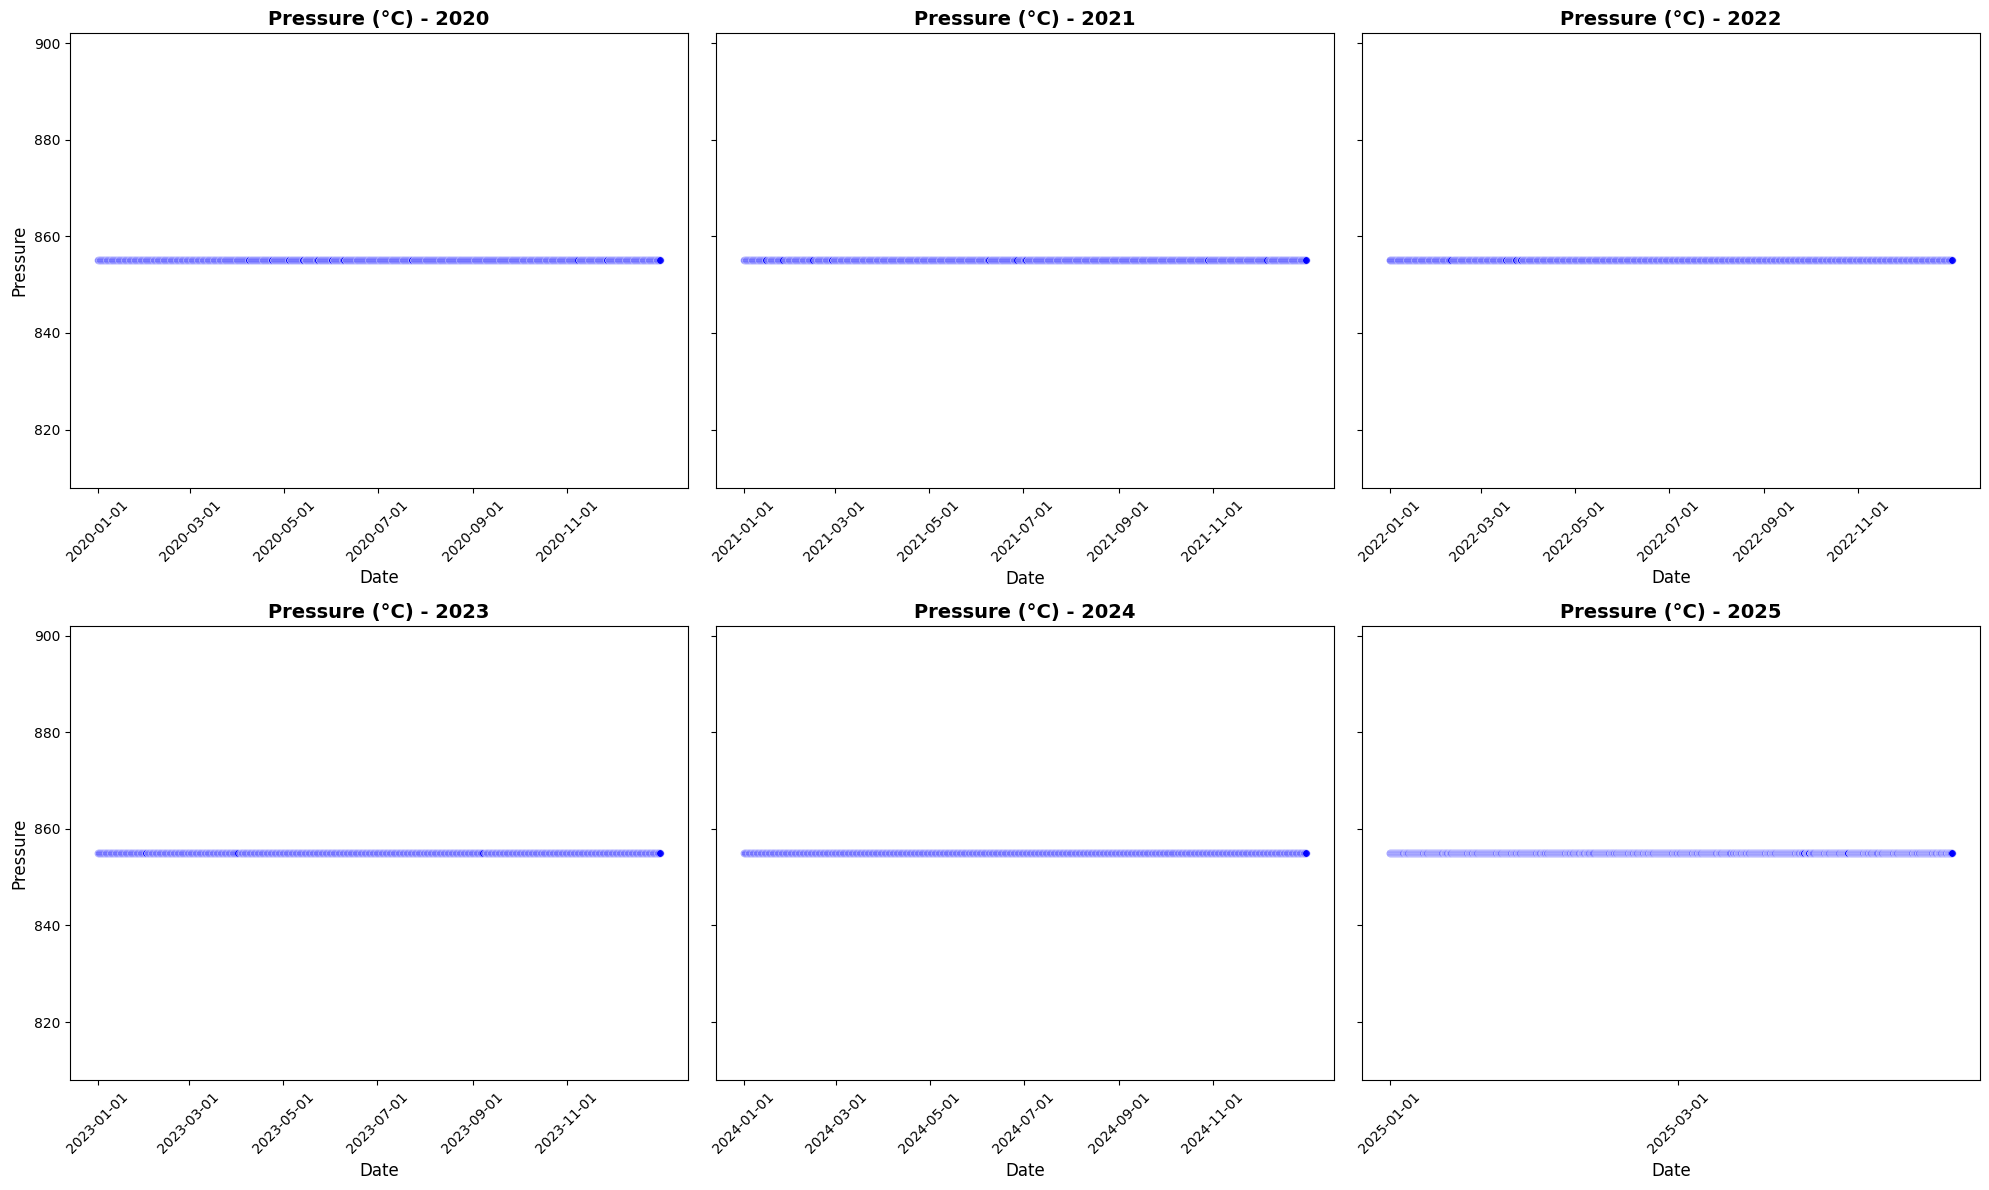

None


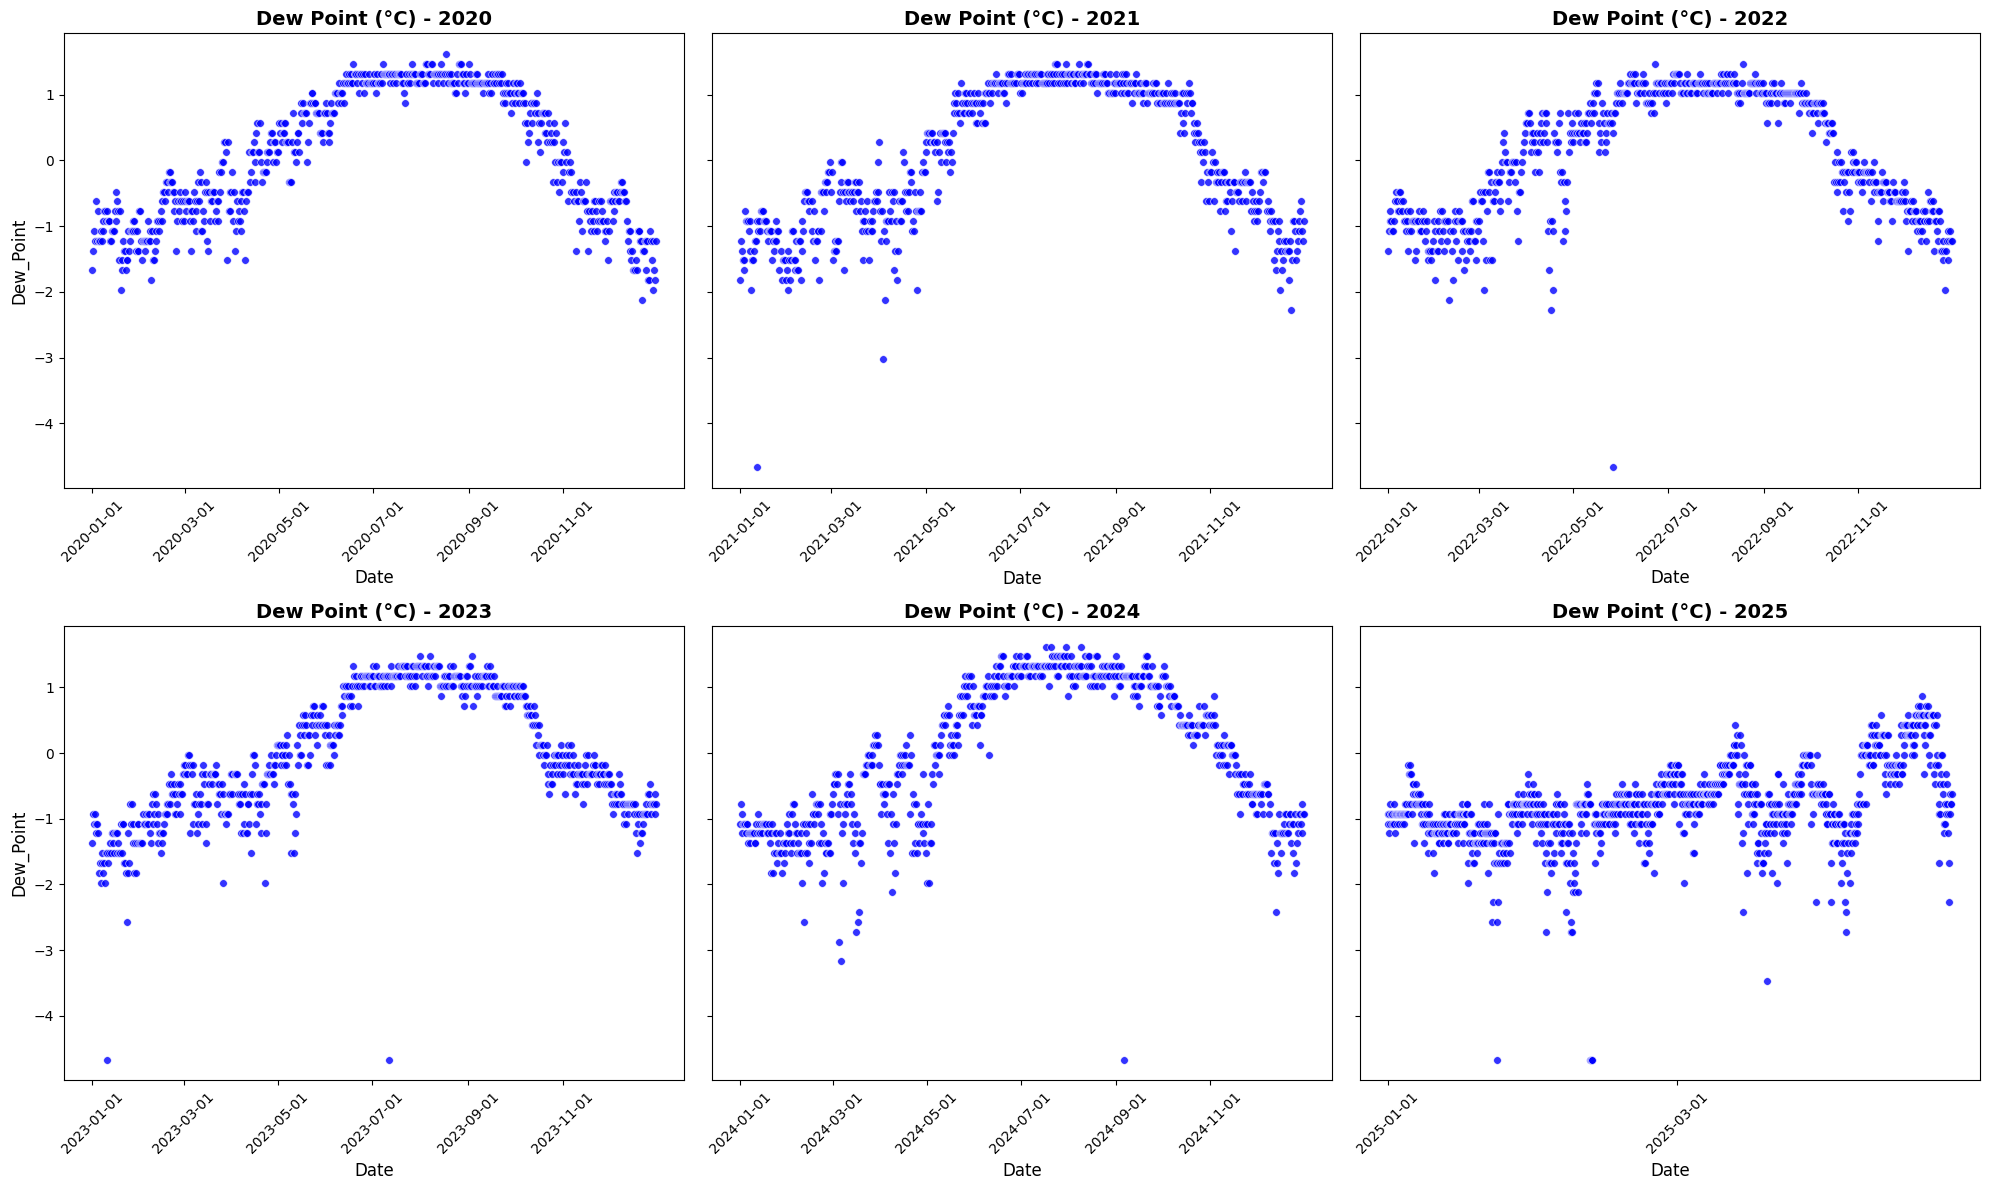

None


In [ ]:
# Yearly plot after removing anomalies
print(plot_yearly_grid(mt_df,'timestamp', 'temperature', 'Temperature (°C)'))
print(plot_yearly_grid(mt_df,'timestamp', 'pressure', 'Pressure (°C)'))
print(plot_yearly_grid(mt_df,'timestamp', 'dew_point', 'Dew Point (°C)'))

In [ ]:

mt_df['is_windy'] = mt_df['condition'].str.contains('/ Windy').astype(int)    # Create binary windy flag
mt_df['condition_base'] = mt_df['condition'].str.replace(' / Windy', '', regex=False)   # Clean condition by removing ' / Windy'

condition_counts = mt_df['condition_base'].value_counts()   # Count frequencies
rare_conditions = condition_counts[condition_counts < 100].index    # Define a threshold for rare categories, e.g. < 100
mt_df['condition'] = mt_df['condition_base'].replace(rare_conditions, 'Other')    # Replace rare categories with 'Other'
mt_df.drop(columns=['condition_base'], inplace=True)


In [ ]:
# print(hd_df.info())
# print(hd_df['date'].value_counts())

In [ ]:
# Sort and deduplicate rows
hd_df_sorted = hd_df.sort_values(['date', 'holiday'], ascending=[True, False])  # Higher holiday value first
hd_unique_df = hd_df_sorted.drop_duplicates(subset='date')[['date', 'holiday']]

KeyError: 'holiday'

### Process Holiday Dataset


> The meteorological data is currently recorded at 30-minute intervals.
To facilitate daily-level analysis and modeling, this half-hourly data needs to be aggregated into a daily summary format.




In [ ]:
mt_df['date'] = mt_df['timestamp'].dt.date

mt_daily_df = mt_df.groupby('date').agg({
    'temperature': 'mean',       # average daily temperature
    'dew_point': 'mean',         # average dew point
    'humidity': 'mean',          # average humidity
    'wind_speed': 'max',         # max wind speed of the day
    'pressure': 'mean',          # average daily pressure
    'wind_sin': 'mean',          # average of circular wind component
    'wind_cos': 'mean',          # average of circular wind component
    'is_calm': 'max',             # max from 0 or 1
    'is_var': 'max',              # max from 0 or 1
    'is_windy': 'max',            # max from 0 or 1
    'condition': lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan,  # most frequent condition
})
mt_daily_df.reset_index(inplace=True)
mt_daily_df['date'] = pd.to_datetime(mt_daily_df['date'])

##  Merge Air Quality Data + Meteorological Data + Holiday Data by Date

In [ ]:
# Merge Holiday data with mt_daily_df
mthd_daily_df = mt_daily_df.merge(hd_unique_df, on='date', how='left')

# Fill missing holiday values with 0
mthd_daily_df['holiday'] = mthd_daily_df['holiday'].fillna(0).astype(int)

In [ ]:
# Merge AQ and MT data
mthdaq_df = pd.merge(aq_df[['date', 'pm25_class']], mthd_daily_df, on='date', how='inner')

In [ ]:
le = LabelEncoder()
mthdaq_df['pm25_class'] = le.fit_transform(mthdaq_df['pm25_class'])

for i, class_label in enumerate(le.classes_):
    print(f"{i}: {class_label}")

print(mthdaq_df['pm25_class'].value_counts())
print(mthdaq_df['condition'].value_counts())